In [1]:
import math
from statistics import mean, stdev
import numpy as np
import pandas as pd
import pandas.io.sql as pd_sql
from scipy.stats import describe
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from functions.formatting import snake_to_pascal_case, add_space_to_prefix
from functions.plotting import plot_single_scatter, plot_qq

with open('.db/postgres.json') as f:
    cred = json.load(f)
    username = cred.get("user")
    password = cred.get("password")
    host = cred.get("host")
    port = cred.get("port")
    
db_name = "mountain_project"
connection_str = f'postgres://{username}:{password}@{host}:{port}/{db_name}' # sqlalchemy connection args

In [2]:
save=True

# Get Data

In [3]:
query = """
SELECT b.avg_stars, b.length_, b.grade,
       r.star_ratings, r.on_to_do_lists, r.ticks,
       t.log_star_ratings, t.log_ticks, t.log_length, t.log_on_to_do_lists,
       t.sqrt_star_ratings, t.sqrt_ticks, t.sqrt_avg_stars, t.sqrt_length, t.sqrt_grade
FROM routes b
LEFT JOIN ratings r ON b.url_id = r.url_id
LEFT JOIN feature_transforms t ON b.url_id = t.url_id
WHERE b.area_name IN ('buttermilks', 'druid_stones', 'happy_boulders', 'sad_boulders')
  AND length_ IS NOT NULL
;
"""
df = pd_sql.read_sql(query, connection_str) # grab data as a dataframe
df = df.reset_index(drop=True)
df.columns = [snake_to_pascal_case(col) for col in df.columns] # rename columns
df.columns = [add_space_to_prefix(col, ['Log', 'Sqrt']) for col in df.columns] # Add space before Log or Sqrt
df.head()

,AvgStars,Length,Grade,StarRatings,OnToDoLists,Ticks,Log StarRatings,Log Ticks,Log Length,Log OnToDoLists,Sqrt StarRatings,Sqrt Ticks,Sqrt AvgStars,Sqrt Length,Sqrt Grade
0,1.3,10.0,-1.00,30,8,52,1.491362,1.724276,1.041393,0.954243,5.477226,7.211103,1.140175,3.162278,0.000000
1,2.0,15.0,-1.00,1,0,1,0.301030,0.301030,1.204120,0.000000,1.000000,1.000000,1.414214,3.872983,0.000000
2,2.2,18.0,-0.25,41,11,87,1.623249,1.944483,1.278754,1.079181,6.403124,9.327379,1.483240,4.242641,0.866025
3,2.8,18.0,-0.25,84,49,168,1.929419,2.227887,1.278754,1.698970,9.165151,12.961481,1.673320,4.242641,0.866025
4,1.8,12.0,-0.25,46,12,102,1.672098,2.012837,1.113943,1.113943,6.782330,10.099505,1.341641,3.464102,0.866025


# Pairgrid

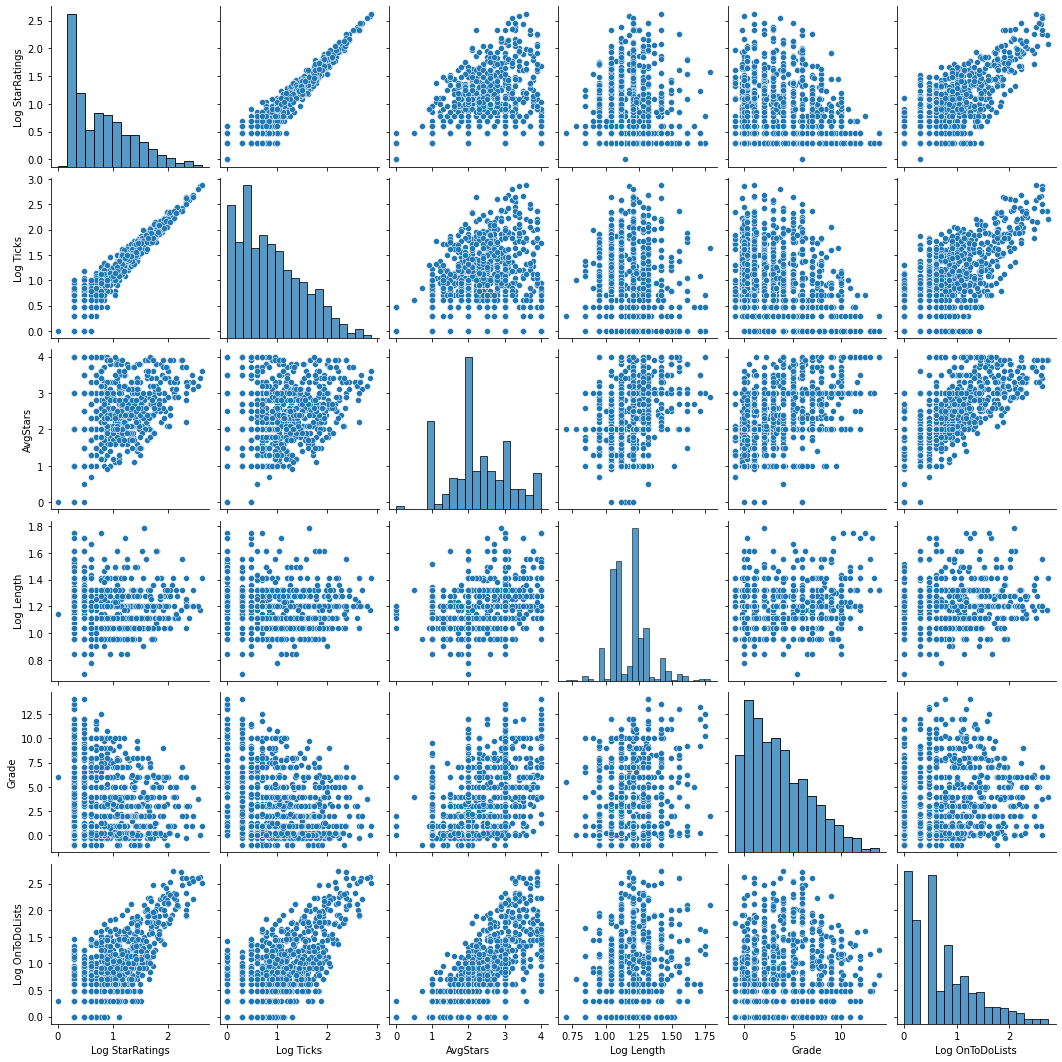

In [4]:
# Pairplot
features_target_list = ['Log StarRatings', 'Log Ticks', 'AvgStars', 'Log Length', 'Grade', # features
                        'Log OnToDoLists'] # target
sns.pairplot(df[features_target_list])
if save:
    plt.savefig("figures/log-linear/log-linear-pairplot.png", transparent=True, bbox_inches="tight")

# Log Linear Regression

In [5]:
# Used for K-fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 72)
scaler = StandardScaler()

In [6]:
# Scikit Learn's LinearRegression with Log Variables

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(df.drop(columns = ['Log OnToDoLists']), df['Log OnToDoLists'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Log StarRatings', 'Log Ticks', 'AvgStars', 'Log Length', 'Grade']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

# KFold Cross-Validation
r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    
    # Make the split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 
    
    # Rebalance train features, no need to rebalance validation set, resample is better than smote
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)  # Scale resampled features
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)  # Scale validation features
    
    ols_model = sm.OLS(target_train_cv_array, sm.add_constant(features_train_cv_scaled_array))
    ols_results = ols_model.fit() # Fit model
    
    # Collect results on the validation set
    SSE = sum((10**target_val_cv_array-1 - 10**ols_results.predict(sm.add_constant(features_val_cv_scaled_array))-1)**2)
    SST = sum((10**target_val_cv_array-1 - 10**np.mean(target_val_cv_array)-1)**2)
    r2_cv_list.append(1-SSE/SST)

print(r2_cv_list)
print('val_r2_score: ', mean(r2_cv_list),' +/- ', stdev(r2_cv_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

# Fit model
ols_model = sm.OLS(target_train_ser, sm.add_constant(features_train_scaled_array))
ols_results = ols_model.fit()

# Save results for comparison later
OLS_array = 10**ols_results.predict(sm.add_constant(features_test_scaled_array))-1

# Collect results on the test set
SSE = sum((10**target_test_ser-1 - OLS_array)**2)
SST = sum((10**target_test_ser-1 - 10**np.mean(target_test_ser)-1)**2)

print('test_r2_score: ', 1-SSE/SST) #Get score
print(list(ols_results.params[1:]))

[0.7683539164262572, 0.8594531568618028, 0.5969286631898134, 0.6626570161372721, 0.7092653183922506]
val_r2_score:  0.7193316142014792  +/-  0.10041545651236782
test_r2_score:  0.771315978939606
[0.28278002204864017, 0.12807485302286084, 0.24719465237837301, 0.03278768646356553, 0.047777245107318206]


In [7]:
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:        Log OnToDoLists   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     649.4
Date:                Sun, 04 Oct 2020   Prob (F-statistic):          4.61e-279
Time:                        21:20:01   Log-Likelihood:                -114.71
No. Observations:                 808   AIC:                             241.4
Df Residuals:                     802   BIC:                             269.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7440      0.010     75.548      0.0

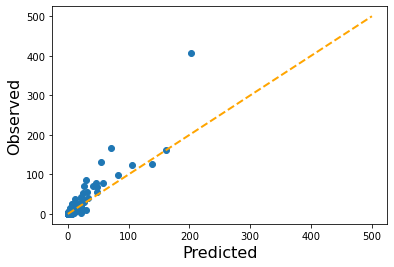

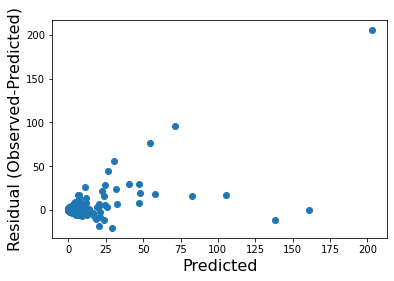

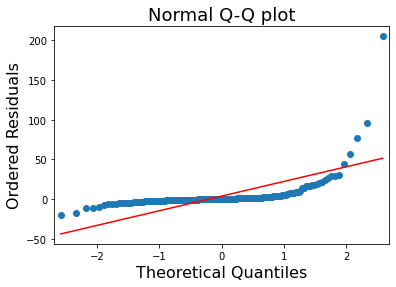

In [8]:
# inputs
x = 10**ols_results.predict(sm.add_constant(features_test_scaled_array))-1
y = 10**target_test_ser-1


# Predicted vs. Observed
predict_obs_df = pd.DataFrame({'predicted': x, 'observed': y})
fig = plot_single_scatter(predict_obs_df, 'predicted', 'observed',
                          xlabel='Predicted', ylabel='Observed',
                          color=None, figsize=None)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
if save:
    plt.savefig("figures/log-linear/observed-vs-predicted.png", transparent=True, bbox_inches="tight")


# Predicted vs. Residual
predict_res_df = pd.DataFrame({'predicted': x, 'residual': y-x})
fig = plot_single_scatter(predict_res_df, 'predicted', 'residual',
                          xlabel='Predicted', ylabel='Residual (Observed-Predicted)',
                          color=None, figsize=None)
if save:
    plt.savefig("figures/log-linear/residual-vs-predicted.png", transparent=True, bbox_inches="tight")

    
# QQ Plot
fig = plot_qq(predict_res_df['residual'], "Theoretical Quantiles", "Ordered Residuals", "Normal Q-Q plot")
if save:
    plt.savefig("figures/log-linear/normal-qq-plot.png", transparent=True, bbox_inches="tight")

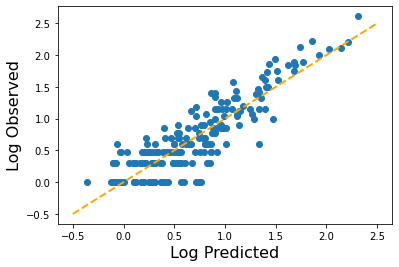

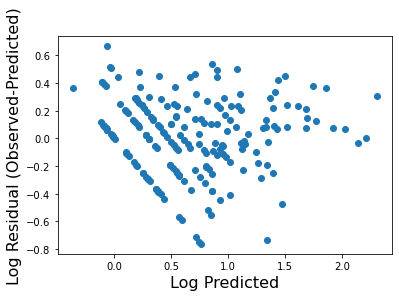

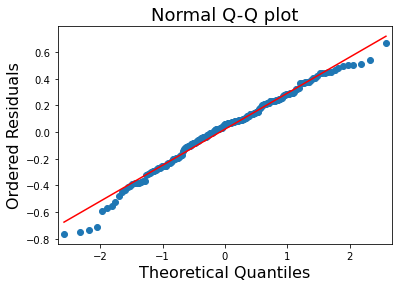

In [9]:
# inputs
x = ols_results.predict(sm.add_constant(features_test_scaled_array))
y = target_test_ser


# Predicted vs. Observed
predict_obs_df = pd.DataFrame({'predicted': x, 'observed': y})
fig = plot_single_scatter(predict_obs_df, 'predicted', 'observed',
                          xlabel='Log Predicted', ylabel='Log Observed',
                          color=None, figsize=None)
plt.plot([-0.5, 2.5], [-0.5, 2.5], c='orange', lw = 2, ls='--', label= "Equal")
if save:
    plt.savefig("figures/log-linear/log_observed-vs-log_predicted.png", transparent=True, bbox_inches="tight")


# Predicted vs. Residual
predict_res_df = pd.DataFrame({'predicted': x, 'residual': y-x})
fig = plot_single_scatter(predict_res_df, 'predicted', 'residual',
                          xlabel='Log Predicted', ylabel='Log Residual (Observed-Predicted)',
                          color=None, figsize=None)
if save:
    plt.savefig("figures/log-linear/log_residual-vs-log_predicted.png", transparent=True, bbox_inches="tight")

    
# QQ Plot
fig = plot_qq(predict_res_df['residual'], "Theoretical Quantiles", "Ordered Residuals", "Normal Q-Q plot")
if save:
    plt.savefig("figures/log-linear/log-qq-plot.png", transparent=True, bbox_inches="tight")

In [10]:
# Linear Regression is overestimating
X = OLS_array
y = 10**target_test_ser-1
len(list(filter(lambda x: x<=0, y-X)))

85

In [11]:
# Fit model
ols_new_model = sm.OLS(y, sm.add_constant(X))
ols_new_results = ols_new_model.fit()
ols_new_results.params

const   -1.095139
x1       1.479617
dtype: float64

# Poisson Regression

In [12]:
# Statsmodels GLM Poisson

# Set aside 20% of data for final test
features_train_all_df, features_test_all_df, target_train_ser, target_test_ser = train_test_split(df.drop(columns = ['OnToDoLists']), df['OnToDoLists'], test_size=.2, random_state=42)

# Choose features, KFold requires ndarray inputs
features_list = ['Sqrt StarRatings', 'Sqrt Ticks', 'Sqrt AvgStars', 'Sqrt Length', 'Sqrt Grade']

features_train_chosen_df = features_train_all_df[features_list]
features_train_chosen_array = np.array(features_train_chosen_df)
features_test_chosen_df = features_test_all_df[features_list]
features_test_chosen_array = np.array(features_test_chosen_df)
target_train_array = np.array(target_train_ser)
target_test_array = np.array(target_test_ser)

r2_cv_list = [] # Collect the cross-validation results

for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):

    # Make split
    features_train_cv_array, target_train_cv_array = features_train_chosen_array[train_index], target_train_array[train_index]
    features_val_cv_array, target_val_cv_array = features_train_chosen_array[val_cv_index], target_train_array[val_cv_index] 

    # Standard Scaler on Features
    features_train_cv_scaled_array = scaler.fit_transform(features_train_cv_array)
    features_val_cv_scaled_array = scaler.transform(features_val_cv_array)

    features_train_cv_scaled_df = pd.DataFrame(features_train_cv_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_train_cv_scaled_df['OnToDoLists'] = target_train_cv_array
    features_val_cv_scaled_df = pd.DataFrame(features_val_cv_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
    features_val_cv_scaled_df['OnToDoLists'] = target_val_cv_array

    # Fit model
    poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_cv_scaled_df, family=sm.families.Poisson())
    poisson_glm_results = poisson_glm_model.fit()

    # Collect results
    SSE = sum((target_val_cv_array - poisson_glm_results.predict(features_val_cv_scaled_df))**2)
    SST = sum((target_val_cv_array - np.mean(target_val_cv_array))**2)
    r2_cv_score = 1-SSE/SST
    r2_cv_list.append(r2_cv_score)

r2_cv_filtered_list = list(filter(lambda x: x >= 0, r2_cv_list))
print(r2_cv_list)
print(r2_cv_filtered_list)
print('r2_cv_score: ', mean(r2_cv_filtered_list),' +/- ', stdev(r2_cv_filtered_list))

# Test
features_train_scaled_array = scaler.fit_transform(features_train_chosen_df)
features_test_scaled_array = scaler.transform(features_test_chosen_df)

features_train_scaled_df = pd.DataFrame(features_train_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_train_scaled_df['OnToDoLists'] = target_train_array
features_test_scaled_df = pd.DataFrame(features_test_scaled_array).rename(columns = {0: 'Sqrt_StarRatings', 1:'Sqrt_Ticks', 2:'Sqrt_Avg_Stars', 3: 'Sqrt_Length', 4: 'Sqrt_Grade'})
features_test_scaled_df['OnToDoLists'] = target_test_array

poisson_glm_model = smf.glm("OnToDoLists ~ Sqrt_StarRatings + Sqrt_Ticks + Sqrt_Avg_Stars + Sqrt_Length + Sqrt_Grade", data=features_train_scaled_df, family=sm.families.Poisson())
poisson_glm_results = poisson_glm_model.fit()

# Save results for comparison
poisson_array = poisson_glm_results.predict(features_test_scaled_df)

SSE = sum((target_test_array - poisson_array)**2)
SST = sum((target_test_array - np.mean(target_test_array))**2)
r2_test_score = 1-SSE/SST

print('r2_test_score: ', r2_test_score) #Get score
print(list(poisson_glm_results.params[1:]))

[0.8657855228408854, -2.0352830220584437, 0.7645869947134964, 0.9004285574116463, 0.696049418116035]
[0.8657855228408854, 0.7645869947134964, 0.9004285574116463, 0.696049418116035]
r2_cv_score:  0.8067126232705157  +/-  0.09361836951507316
r2_test_score:  0.821212146606273
[1.5934518726975178, -1.0234375571508485, 1.1188169184448393, -0.06300388327775883, -0.03383125234547074]


In [13]:
# Why is the second fold overfitting?

val_cv_index_list = []
for train_index, val_cv_index in kf.split(features_train_chosen_array, target_train_array):
    val_cv_index_list.append(val_cv_index)

for i in range(5):
    print(describe(target_train_array[val_cv_index_list[i]]))

DescribeResult(nobs=162, minmax=(0, 408), mean=22.11111111111111, variance=3751.5155279503106, skewness=4.328599631645833, kurtosis=19.726683129054543)
DescribeResult(nobs=162, minmax=(0, 324), mean=16.58641975308642, variance=1882.529752319607, skewness=4.765837387359696, kurtosis=25.968169677111003)
DescribeResult(nobs=162, minmax=(0, 546), mean=24.555555555555557, variance=4560.173913043478, skewness=5.16754438486624, kurtosis=30.16983478582852)
DescribeResult(nobs=161, minmax=(0, 511), mean=20.664596273291924, variance=3881.8868012422363, skewness=5.343271750521604, kurtosis=32.60990966392185)
DescribeResult(nobs=161, minmax=(0, 412), mean=16.608695652173914, variance=1866.1146739130431, skewness=5.860591047675372, kurtosis=44.48187970726255)


In [14]:
print(poisson_glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            OnToDoLists   No. Observations:                  808
Model:                            GLM   Df Residuals:                      802
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4488.9
Date:                Sun, 04 Oct 2020   Deviance:                       6537.1
Time:                        21:20:02   Pearson chi2:                 7.18e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.7834      0.017  

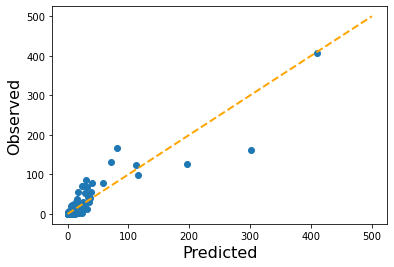

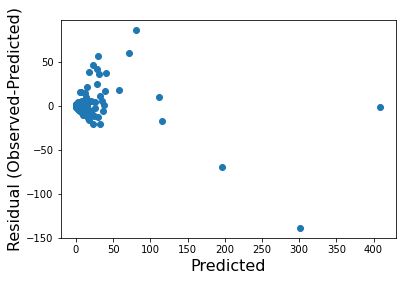

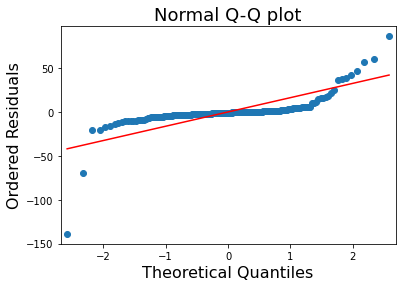

In [15]:
# inputs
x = poisson_glm_results.predict(features_test_scaled_df)
y = target_test_array


# Predicted vs. Observed
predict_obs_df = pd.DataFrame({'predicted': x, 'observed': y})
fig = plot_single_scatter(predict_obs_df, 'predicted', 'observed',
                          xlabel='Predicted', ylabel='Observed',
                          color=None, figsize=None)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")
if save:
    plt.savefig("figures/poisson/observed-vs-predicted.png", transparent=True, bbox_inches="tight")


# Predicted vs. Residual
predict_res_df = pd.DataFrame({'predicted': x, 'residual': y-x})
fig = plot_single_scatter(predict_res_df, 'predicted', 'residual',
                          xlabel='Predicted', ylabel='Residual (Observed-Predicted)',
                          color=None, figsize=None)
if save:
    plt.savefig("figures/poisson/residual-vs-predicted.png", transparent=True, bbox_inches="tight")

    
# QQ Plot
fig = plot_qq(predict_res_df['residual'], "Theoretical Quantiles", "Ordered Residuals", "Normal Q-Q plot")
if save:
    plt.savefig("figures/poisson/normal-qq-plot.png", transparent=True, bbox_inches="tight")

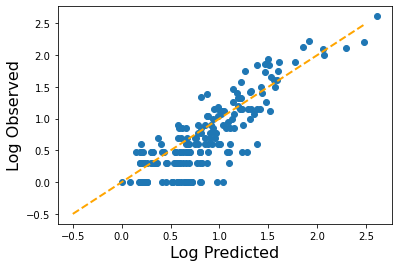

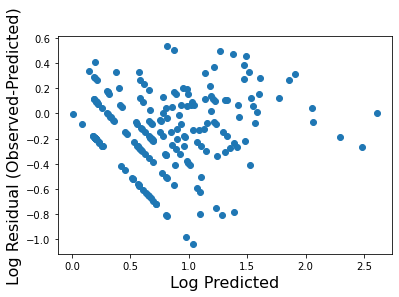

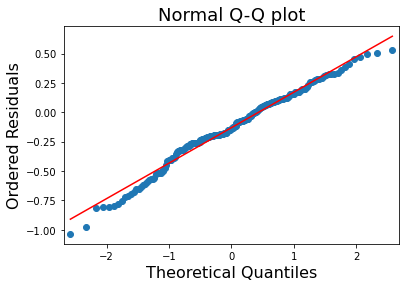

In [16]:
# inputs
x = np.log(np.array(poisson_glm_results.predict(features_test_scaled_df)+1))/math.log(10)
y = np.log(target_test_array+1)/math.log(10)


# Predicted vs. Observed
predict_obs_df = pd.DataFrame({'predicted': x, 'observed': y})
fig = plot_single_scatter(predict_obs_df, 'predicted', 'observed',
                          xlabel='Log Predicted', ylabel='Log Observed',
                          color=None, figsize=None)
plt.plot([-0.5, 2.5], [-0.5, 2.5], c='orange', lw = 2, ls='--', label= "Equal")
if save:
    plt.savefig("figures/poisson/log_observed-vs-log_predicted.png", transparent=True, bbox_inches="tight")


# Predicted vs. Residual
predict_res_df = pd.DataFrame({'predicted': x, 'residual': y-x})
fig = plot_single_scatter(predict_res_df, 'predicted', 'residual',
                          xlabel='Log Predicted', ylabel='Log Residual (Observed-Predicted)',
                          color=None, figsize=None)
if save:
    plt.savefig("figures/poisson/log_residual-vs-log_predicted.png", transparent=True, bbox_inches="tight")

    
# QQ Plot
fig = plot_qq(predict_res_df['residual'], "Theoretical Quantiles", "Ordered Residuals", "Normal Q-Q plot")
if save:
    plt.savefig("figures/poisson/normal-qq-plot.png", transparent=True, bbox_inches="tight")

In [17]:
# Poisson is underestimating
X = poisson_array
y = target_test_array
len(list(filter(lambda x: x<=0, y-X)))

131

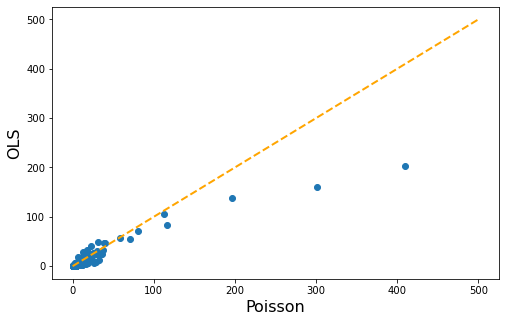

In [18]:
x = poisson_array
y = OLS_array
plot_df = pd.DataFrame({'poisson': x, 'ols': y})

fig = plot_single_scatter(plot_df, 'poisson', 'ols',
                          xlabel='Poisson', ylabel='OLS',
                          color=None)
plt.plot([0, 500], [0, 500], c='orange', lw = 2, ls='--', label= "Equal")

if save:
    plt.savefig("figures/compare/ols-vs-poisson.png", transparent=True, bbox_inches="tight")